In [19]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

# Define transforms for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the Flowers102 dataset
# Set download=True if you haven't downloaded it yet
flowers_dataset = datasets.Flowers102(
    root='./data',
    split='train',
    download=True,
    transform=transform
)

print(f"Dataset size: {len(flowers_dataset)}")
print(f"Number of classes: {len(flowers_dataset.classes)}")


Dataset size: 1020
Number of classes: 102


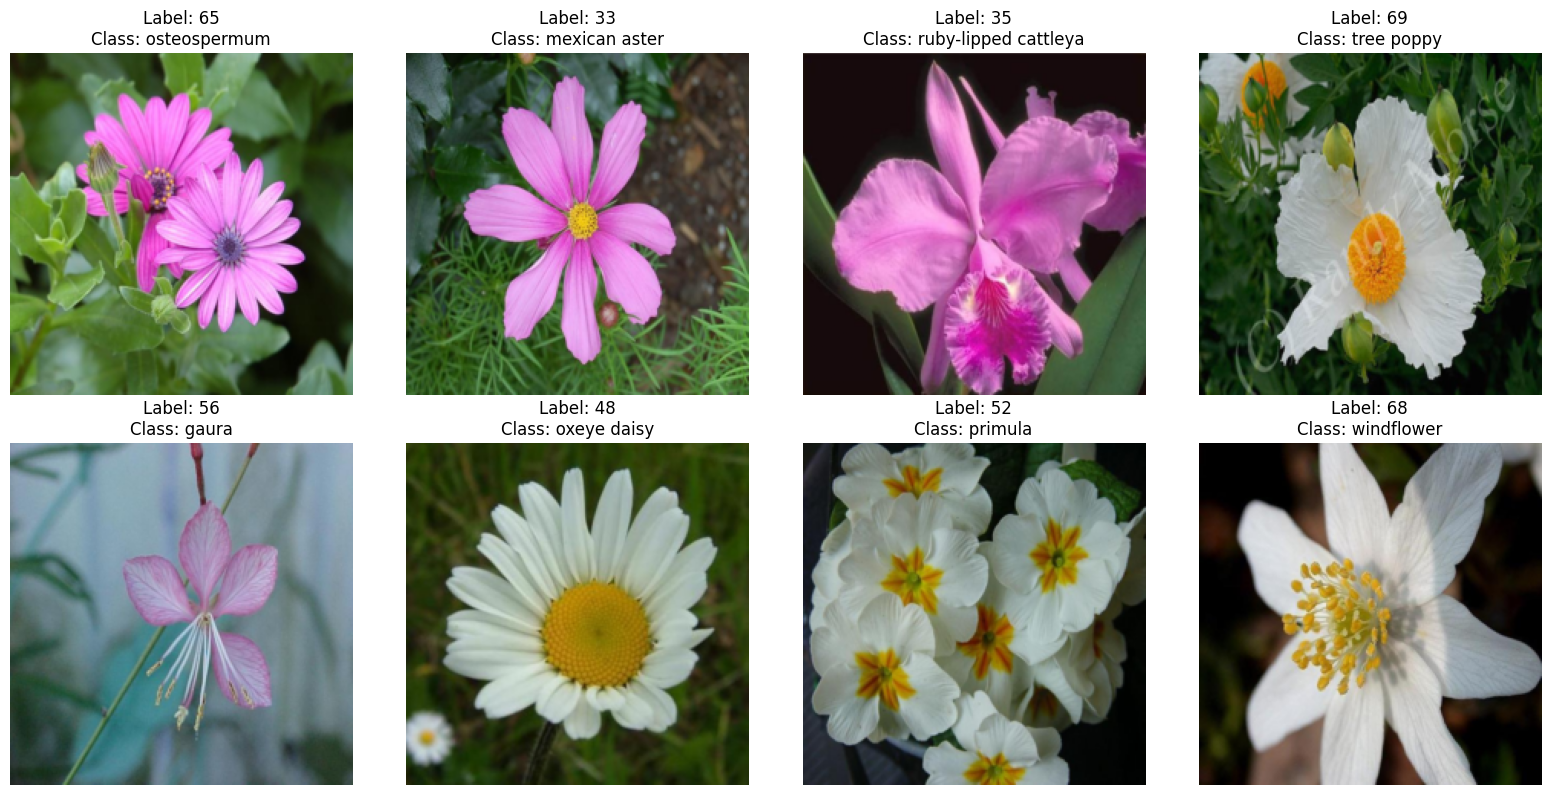

In [20]:
# Sample random images from the dataset
def sample_and_display_images(dataset, num_samples=8, figsize=(16, 8)):
    """
    Sample random images from the dataset and display them.
    
    Args:
        dataset: PyTorch dataset
        num_samples: Number of images to sample
        figsize: Figure size for matplotlib
    """
    # Get random indices
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    # Create subplot
    fig, axes = plt.subplots(2, 4, figsize=figsize)
    axes = axes.flatten()
    
    for idx, ax in zip(indices, axes):
        image, label = dataset[idx]
        
        # Convert tensor to numpy for display
        # PyTorch tensors are (C, H, W), need to convert to (H, W, C) for matplotlib
        image_np = image.permute(1, 2, 0).numpy()
        
        # Clamp values to [0, 1] range
        image_np = np.clip(image_np, 0, 1)
        
        ax.imshow(image_np)
        ax.set_title(f'Label: {label}\nClass: {dataset.classes[label]}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Sample and display images
sample_and_display_images(flowers_dataset, num_samples=8)


In [22]:
# Install PyTorch Lightning in Colab / if needed (uncomment if not installed)
%pip install -q pytorch-lightning

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torchvision import models

pl.seed_everything(42)

IMG_SIZE = 224
BATCH_SIZE = 64
NUM_CLASSES = len(flowers_dataset.classes)

# Transforms: strong augmentation for train, simple resize for val/test
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.ToTensor(),
])

eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

train_ds = datasets.Flowers102(
    root="./data",
    split="train",
    download=False,
    transform=train_transform,
)
val_ds = datasets.Flowers102(
    root="./data",
    split="val",
    download=False,
    transform=eval_transform,
)
test_ds = datasets.Flowers102(
    root="./data",
    split="test",
    download=False,
    transform=eval_transform,
)

train_loader_pl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader_pl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader_pl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

len(train_ds), len(val_ds), len(test_ds)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 72.4 MB/s eta 0:00:00


INFO:lightning_fabric.utilities.seed:Seed set to 42


(1020, 1020, 6149)

In [24]:
# LightningModule with ResNet18 backbone and transfer learning

class FlowersResNet(pl.LightningModule):
    def __init__(self, num_classes=NUM_CLASSES, lr=1e-4, weight_decay=1e-4):
        super().__init__()
        self.save_hyperparameters()

        # Load pretrained ResNet18
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        # Replace the final FC layer
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)

        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    def forward(self, x):
        return self.backbone(x)

    def _shared_step(self, batch, stage):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()

        self.log(f"{stage}_loss", loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log(f"{stage}_acc", acc, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        self._shared_step(batch, "val")

    def test_step(self, batch, batch_idx):
        self._shared_step(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.5, patience=3
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }


lit_model = FlowersResNet()
lit_model


FlowersResNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [ ]:
# Train with Lightning: checkpoints + early stopping

checkpoint_cb = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    save_last=True,
    filename="flowers-resnet18-{epoch:02d}-{val_loss:.3f}-{val_acc:.3f}",
)

early_stop_cb = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=8,
    verbose=True,
)

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="auto",
    devices="auto",
    precision="16-mixed" if torch.cuda.is_available() else 32,
    callbacks=[checkpoint_cb, early_stop_cb],
    log_every_n_steps=10,
)

trainer.fit(lit_model, train_dataloaders=train_loader_pl, val_dataloaders=val_loader_pl)


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return _C._get_float32_matmul_precision()
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that h

┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ backbone  │ ResNet           │ 11.2 M │ train │     0 │
│ 1 │ criterion │ CrossEntropyLoss │      0 │ train │     0 │
└───┴───────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 11.2 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 11.2 M                                                                                               
Total estimated model params size (MB): 44                                                                         
Modules in train mode: 69                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 4.097


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.836 >= min_delta = 0.0. New best score: 3.261


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.539 >= min_delta = 0.0. New best score: 2.722


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.349 >= min_delta = 0.0. New best score: 2.374


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.265 >= min_delta = 0.0. New best score: 2.109


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.156 >= min_delta = 0.0. New best score: 1.953


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.130 >= min_delta = 0.0. New best score: 1.823


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.108 >= min_delta = 0.0. New best score: 1.715


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.096 >= min_delta = 0.0. New best score: 1.619


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.090 >= min_delta = 0.0. New best score: 1.530


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.502


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 1.446


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.440


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.427


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 1.380


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.370


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.363


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.351


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.348


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.342


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.339


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.333


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.325


INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 8 records. Best score: 1.325. Signaling Trainer to stop.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8890876770019531     │
│         test_loss         │    1.4218472242355347     │
└───────────────────────────┴───────────────────────────┘

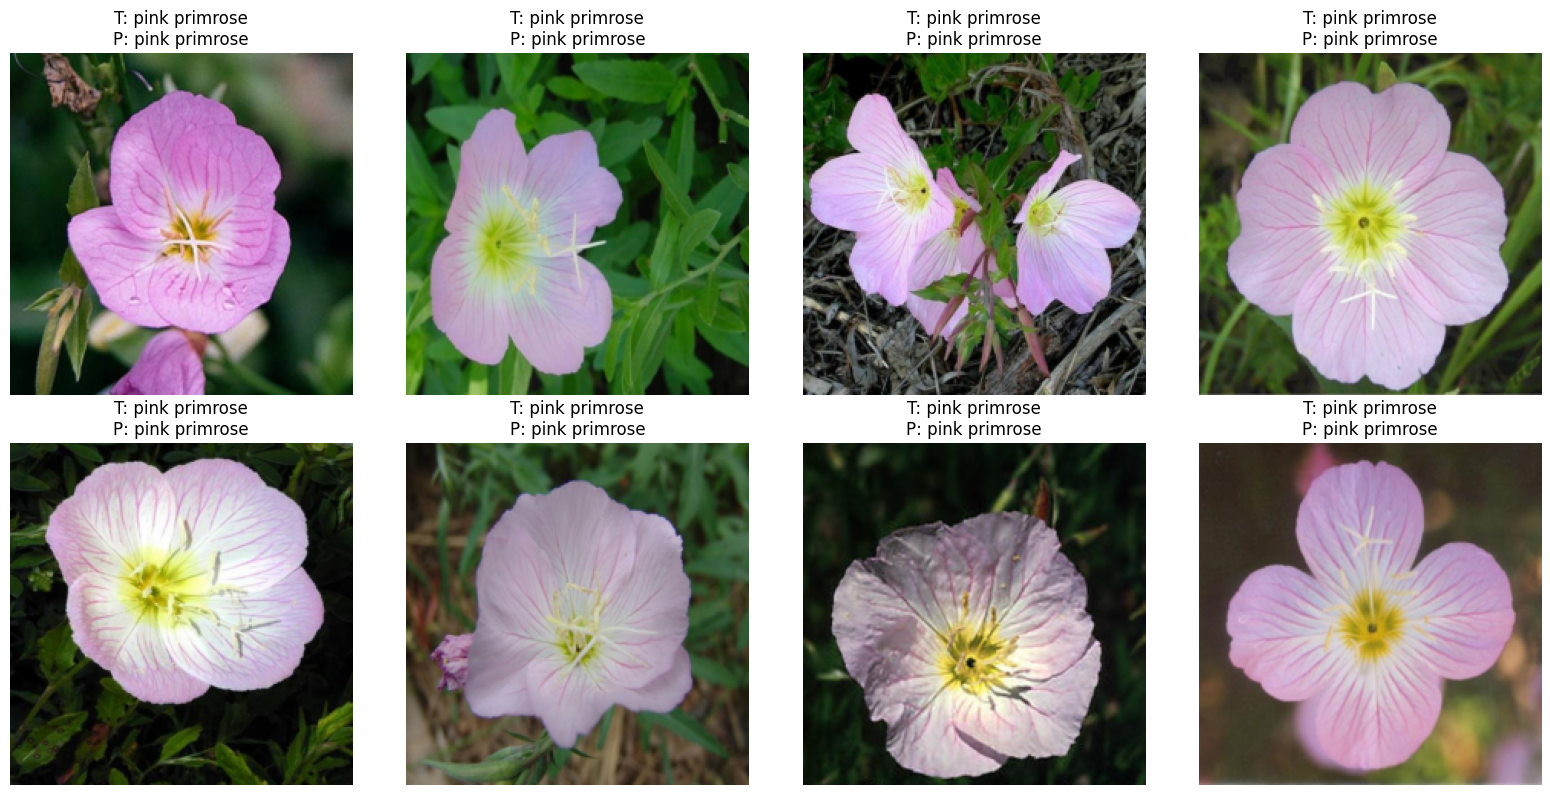

In [ ]:
# Test best model and visualize a few predictions

trainer.test(lit_model, dataloaders=test_loader_pl)

# Simple prediction viz
lit_model.eval()

images, labels = next(iter(test_loader_pl))
images = images[:8]
labels = labels[:8]

with torch.no_grad():
    logits = lit_model(images)
    preds = torch.argmax(logits, dim=1)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    img_np = images[i].permute(1, 2, 0).numpy()
    img_np = np.clip(img_np, 0, 1)
    ax.imshow(img_np)
    true_label = labels[i].item()
    pred_label = preds[i].item()
    ax.set_title(f"T: {flowers_dataset.classes[true_label]}\nP: {flowers_dataset.classes[pred_label]}")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# Save trained Lightning model weights
import os

os.makedirs("Models", exist_ok=True)

save_path = os.path.join("Models", "flowers_resnet18_pl.pt")

# Save just the weights (state_dict)
torch.save(lit_model.state_dict(), save_path)
print(f"Saved model state_dict to: {save_path}")

# You can also save a full Lightning checkpoint if desired:
# ckpt_path = os.path.join("Models", "flowers_resnet18_pl.ckpt")
# trainer.save_checkpoint(ckpt_path)
# print(f"Saved full Lightning checkpoint to: {ckpt_path}")


Saved model state_dict to: Models/flowers_resnet18_pl.pt
